# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

# Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization. statsmodels.graphics.gofplots and scipy.stats.shapiro are used for normality check. Scipy.stats.friedmanchisquare is a non-parametric test used to determine the statistical significance in metric results and the wilcoxon test is used for pairwise comparison of sample data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

Logging to show what's happening in LensKit routines:

In [3]:
from lenskit import util
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


In [4]:
import logging
_log = logging.getLogger('eval-report')

We will use lenskit for training, running, and evaluating recommender algorithms

In [5]:
from lenskit import topn
from lenskit.metrics.predict import rmse

# Load Data

We specify the dataset we will use for our analysis and the main directory from where we read the recommendation and prediction files. From the main directory we find all the directories associated with the dataset and then read the recommendation and predictions files from those directories.

In [6]:
dataset = "ml100k"

In [7]:
# Parameters
dataset = "ml10m"


In [8]:
output_root = Path("runs")

In [9]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [10]:
recs = []
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = pd.read_csv(file)
        rec["algorithm"] = fld.name.split("-")[1]
        recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'algorithm': 'category'})
recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48910800 entries, 0 to 48910799
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   item       int64   
 1   score      float64 
 2   user       int64   
 3   rank       int64   
 4   algorithm  category
dtypes: category(1), float64(1), int64(3)
memory usage: 1.5 GB


In [11]:
rec_algos = recs['algorithm'].unique()
rec_algos

['UUE', 'IALS', 'Pop', 'III', 'ALS', 'Bias', 'IIE']
Categories (7, object): ['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop', 'UUE']

In [12]:
preds = []
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_csv(file)
        pred["algorithm"] = fld.name.split("-")[1]
        preds.append(pred)

preds = pd.concat(preds, ignore_index=True)
preds = preds.astype({'algorithm': 'category'})
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096340 entries, 0 to 2096339
Data columns (total 6 columns):
 #   Column      Dtype   
---  ------      -----   
 0   user        int64   
 1   item        int64   
 2   rating      float64 
 3   timestamp   int64   
 4   prediction  float64 
 5   algorithm   category
dtypes: category(1), float64(2), int64(3)
memory usage: 82.0 MB


We need to load the test data so that we have the ground truths for computing accuracy

In [13]:
split_root = Path("data-split")
split_dir = split_root / dataset

In [14]:
test = []
for file in split_dir.glob("test-*.parquet"):
    test.append(pd.read_parquet(file,).assign(part=file.stem.replace('.parquet', '')))

test = pd.concat(test).rename(columns={
    'user_id': 'user',
    'item_id': 'item',
})
test.head()

,user,item,rating,timestamp,part
index,,,,,
62,3,5505,2.0,1136075848,test-3
54,3,1597,4.5,1133571226,test-3
64,3,5952,3.5,1133570984,test-3
43,3,151,4.5,1133571026,test-3
68,3,7153,4.0,1133571171,test-3


# Top-N Metrics

The topn.RecListAnalysis class computes top-N metrics for recommendation list and takes care of making sure that the recommendations and ground truths are properly matched. Refer to the documentation for detailed explanation of the purpose for the RecListAnalysis class and how the analysis is done - https://lkpy.lenskit.org/en/stable/evaluation/topn-metrics.html

In [15]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.precision)
rla.add_metric(topn.recip_rank)
rla.add_metric(topn.ndcg)
results = rla.compute(recs, test.drop(columns=['rating']), include_missing=True)
results = results.fillna(0)
results.head()

[   INFO] lenskit.topn analyzing 48910800 recommendations (349390 truth rows)


[   INFO] lenskit.topn using rec key columns ['algorithm', 'user']


[   INFO] lenskit.topn using truth key columns ['user']


[   INFO] lenskit.topn numbering truth lists


[   INFO] lenskit.topn numbering rec lists


[   INFO] lenskit.topn collecting metric results


[   INFO] lenskit.topn measured 489108 lists in 30.23s


[   INFO] lenskit.topn filling in missing user info (489108 initial rows)


/home/mde48/micromamba/envs/lkdemo/lib/python3.10/site-packages/lenskit/topn.py:152: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, df in res.groupby(ug_cols):


nrecs  precision  recip_rank      ndcg  ntruth
algorithm user                                                
ALS       6     100.0       0.01    0.010309  0.042542       5
          8     100.0       0.00    0.000000  0.000000       5
          12    100.0       0.00    0.000000  0.000000       5
          16    100.0       0.01    0.025641  0.053122       5
          22    100.0       0.00    0.000000  0.000000       5

We will reshape the 'results' dataframe by stacking the columns to index and then use the bar chart to visualize the performance of our algorithms with respect to the precision, reciprocal rank and ndcg metrics

In [16]:
pltData = (results.drop(columns=['nrecs', 'ntruth']).stack()).reset_index()
pltData.columns = ['algorithm', 'user', 'metric', 'val']
pltData.head()

,algorithm,user,metric,val
0,ALS,6,precision,0.010000
1,ALS,6,recip_rank,0.010309
2,ALS,6,ndcg,0.042542
3,ALS,8,precision,0.000000
4,ALS,8,recip_rank,0.000000


We need to determine if the differences we observe in the performances of the algorithms for the various metrics are statistically significant. To achieve this, we will need to use either a parametric or non-parametric statistical test for comparing the differences. We will consider a parametric test - repeated ANOVA measure cause our sample groups are correlated.

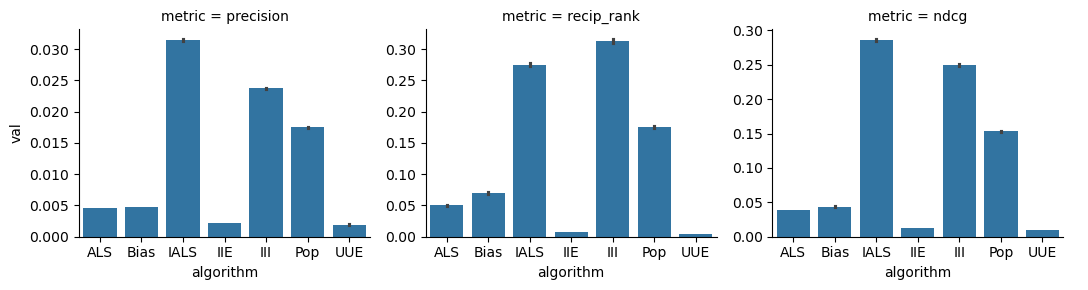

In [17]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=1.2, height=3, sharey=False)

## Prediction RMSE

We will also look at the prediction RMSE.

In [18]:
preds = preds.rename(columns={'score': 'prediction'})
user_rmse = preds.groupby(['algorithm', 'user']).apply(lambda df: rmse(df['prediction'], df['rating']))
user_rmse = user_rmse.reset_index(name='RMSE')

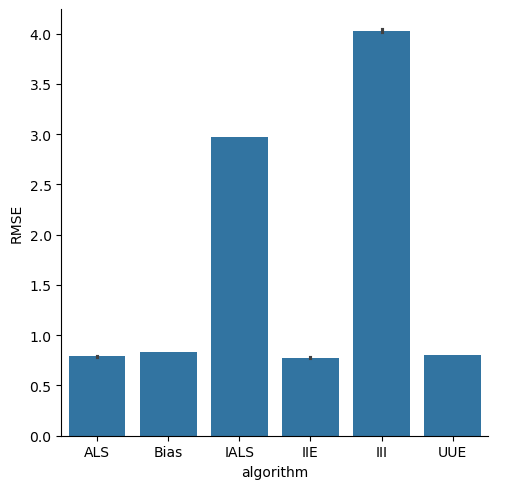

In [19]:
sns.catplot(x='algorithm', y='RMSE', data=user_rmse, kind='bar')

## Save Metrics

We'll now save the top-N recommendation metrics.

In [20]:
saved = results[['recip_rank', 'ndcg']].rename(columns={'ndcg': 'NDCG', 'recip_rank': 'RecipRank'})
saved = saved.groupby('algorithm').agg('mean')
saved

,RecipRank,NDCG
algorithm,,
ALS,0.050287,0.038741
Bias,0.069619,0.043852
IALS,0.275229,0.285604
IIE,0.007768,0.012593
III,0.312870,0.249497
Pop,0.175094,0.153006
UUE,0.004210,0.009815


In [21]:
saved.to_json(f'eval-metrics.{dataset}.json', orient='index')